# Visualising taxa abundance

In [1]:
setwd("/mnt/c/git_repos/blood_microbial_signatures/")
require(tidyverse)
require(ggplot2)
require(data.table)
require(foreach)
require(compositions)
require(ggpubr)
require(scales)
require(ggsci)
require(ggforce)
require(see)
require(doParallel)
require(VennDiagram)
require(randomcoloR)
require(vegan)
# registerDoParallel(cores=8)

Loading required package: tidyverse

Warning message:
“package ‘tidyverse’ was built under R version 4.1.3”
Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tibble’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.3”
Warning message:
“package ‘readr’ was built under R version 4.1.3”
Warning message:
“package ‘purrr’ was built under R version 4.1.3”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
Warning message:
“package ‘stringr’ was built under R version 4.1.3”
Warning messa

## Pre-process data

### Load and parse data

In [2]:
get_meta_cols <- function(meta) {
    meta_cols <- colnames(meta)[grep("kit|flow_cell|instrument_id|site_supplying", colnames(meta))]
    to_exclude <- c("library_prep_kit", "hiseq_xtm_flow_cell_v2_5_id")
    meta_cols <- meta_cols[!(meta_cols %in% to_exclude)]
    return(meta_cols)
}


load_data <- function(file_path) {
    df <- fread(file_path) %>%
        separate(sample, into = c(NA, "npm_research_id"), sep = "\\.")
    return(df)
}


In [3]:
rank <- "S"

to_retain <- fread("data/samples_above_100_microbial_reads.txt")$npm_research_id

meta <- fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv") %>%
    filter(npm_research_id %in% to_retain)

meta_cols <- get_meta_cols(meta)

species_df <- load_data(str_glue("data/taxonomic_profiles/07_abundance_matrix/abundance_matrix.S.pipeline2_210322.tsv")) %>%
    filter(npm_research_id %in% to_retain) %>%
    select(-unclassified, -"Homo sapiens")

prev_df <- fread("results/decontamination/prevalence_RA0.005_read10.csv")

### No. of species after removal of low read count samples

In [4]:
col_sums <- species_df %>% 
select(-npm_research_id) %>%
    colSums()

sum(col_sums != 0)

[1] 8849

In [5]:
fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv") %>%
group_by(site_supplying_sample) %>%
summarise(n = n())

site_supplying_sample,n
<chr>,<int>
GUSTO,969
HELIOS,2286
MEC,2902
PRISM,1257
SEED,1436
TTSH,920


## Basic stats

## Decontamination

#### Load non-contaminant list

In [6]:
# Differential prevalence
diff_prev_nc <- read.csv("results/decontamination/diff_prev_V3/noncontaminants.RA0.005.read_threshold10.max_prev0.25.fold_diff2.txt")$taxa
diff_prev_c <- read.csv("results/decontamination/diff_prev_V3/contaminants.RA0.005.read_threshold10.max_prev0.25.fold_diff2.txt")$taxa

# Correlation filter
corr_nc <- read.csv("results/decontamination/correlation_decontamination/nc.diff_prev_V3.RA0.005.read_threshold10.max_prev0.25.fold_diff2.corr_t0.7.within_batch.S.n9999.txt")$non_contaminant_taxon
corr_c <- read.csv("results/decontamination/correlation_decontamination/contam.diff_prev_V3.RA0.005.read_threshold10.max_prev0.25.fold_diff2.corr_t0.7.within_batch.S.n9999.txt")$contaminant

# Simple batch filter
batch_nc <- read.csv("results/decontamination/simple_batch_decontam/nc.corr_t0.7.within_batch.txt")$taxa

### Set 'absent' taxa to zero

In [7]:
species_zeroed <- species_df %>% 
    select(all_of(colnames(prev_df))) %>%
    column_to_rownames("npm_research_id")

prev_bool_df <- prev_df %>%
    column_to_rownames("npm_research_id")

for(i in seq(ncol(species_zeroed))) {
    species_zeroed[!prev_bool_df[, i], i] <- 0
}

species_filt <- species_zeroed %>% 
    rownames_to_column("npm_research_id") %>%
    select(all_of(c("npm_research_id", batch_nc)))


fwrite(species_zeroed %>% rownames_to_column("npm_research_id"), "results/decontamination/read_matrix.raw.zeroed.csv")

#### Relative abundance

In [8]:
otu_to_RA <- function(df) {
    row_names <- df$npm_research_id
    RA_df <- t(apply(df[, 2:ncol(df)], 1, function(x) {x / sum(x)}))
    
    return(cbind(data.frame(npm_research_id = row_names), as.data.frame(RA_df, check.names = F)))
}

species_filt_RA <- otu_to_RA(species_filt)

#### CLR transform

In [9]:
RA_to_clr <- function(df) {
    row_names <- df$npm_research_id
    clr_df <- clr(df %>% select(where(is.numeric)))
    return(cbind(data.frame(npm_research_id = row_names), as.data.frame(clr_df, check.names = F)))
}

# species_clr <- RA_to_clr(species_RA)
# head(species_clr)

## Max count filter

#### Max read count

In [10]:
max_df <- species_filt %>% 
    select(-npm_research_id) %>%
    pivot_longer(everything(), names_to = "taxa", values_to = "read_count") %>%
    group_by(taxa) %>%
    summarise(max_count = max(read_count)) %>%
    arrange(desc(max_count))

#### Overall prevalence

In [11]:
prev_stats <- apply(prev_df[, 2:ncol(prev_df)], 2, sum) / nrow(prev_df)
overall_prev <- data.frame(taxa = names(prev_stats), overall_prevalence = as.vector(prev_stats))

In [12]:
prev_max <- max_df %>%
    left_join(overall_prev) %>%
    arrange(desc(overall_prevalence)) %>%
    mutate(n_samples = overall_prevalence * nrow(prev_df)) %>%
    arrange(desc(overall_prevalence))
prev_max

Joining with `by = join_by(taxa)`


taxa,max_count,overall_prevalence,n_samples
<chr>,<dbl>,<dbl>,<dbl>
Cutibacterium acnes,22596,0.047458390,422
Moraxella osloensis,2402,0.019118309,170
Human mastadenovirus C,17475,0.018780927,167
Mycolicibacterium aubagnense,1938,0.012145749,108
Lactobacillus iners,1104,0.011920828,106
Lactobacillus crispatus,7799,0.010571300,94
Phyllobacterium zundukense,336,0.009334233,83
Staphylococcus epidermidis,9140,0.008547009,76
Sulfuritalea hydrogenivorans,86,0.008547009,76


In [13]:
prev_max_filt <- prev_max %>% filter(max_count > 100)
prev_max_filt %>%
arrange(desc(max_count))

taxa,max_count,overall_prevalence,n_samples
<chr>,<dbl>,<dbl>,<dbl>
Fusobacterium nucleatum,194199,0.0011246064,10
Cutibacterium acnes,22596,0.0474583896,422
Human mastadenovirus C,17475,0.0187809267,167
Neisseria subflava,15385,0.0015744489,14
Corynebacterium segmentosum,14476,0.0010121457,9
Haemophilus parainfluenzae,12183,0.0020242915,18
Fannyhessea vaginae,10395,0.0023616734,21
Staphylococcus epidermidis,9140,0.0085470085,76
Human betaherpesvirus 6A,8770,0.0020242915,18


In [14]:
prev_max_filt_test <- prev_max %>% filter(max_count > 100)
batch_not_in_final <- batch_nc[!(batch_nc %in% prev_max_filt_test$taxa)]
tibble(taxa = batch_not_in_final) %>%
    separate(taxa, into  = c("Genus"), sep = " ") %>%
    group_by(Genus) %>%
    summarise(n = n()) %>% 
    arrange(desc(n))

Warning message:
“Expected 1 pieces. Additional pieces discarded in 65 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


Genus,n
<chr>,<int>
Paraburkholderia,16
Acinetobacter,4
Burkholderia,4
Corynebacterium,3
Actinomyces,2
Brevibacterium,2
Comamonas,2
Enterobacter,2
Kocuria,2


In [15]:
raw_no <- sum(colSums(species_df %>% select(-npm_research_id)) != 0)
print(str_glue("Raw no. of taxa: {raw_no}"))
print(str_glue("After zero-filter: {ncol(prev_df) - 1}"))
print(str_glue("After diff. prev. filter: {length(diff_prev_nc)}"))
print(str_glue("After corr. filter: {length(corr_nc)}"))
print(str_glue("After batch filter: {length(batch_nc)}"))
print(str_glue("After max. count filter: {nrow(prev_max_filt)}"))

Raw no. of taxa: 8849
After zero-filter: 870
After diff. prev. filter: 708
After corr. filter: 526
After batch filter: 182
After max. count filter: 117


### Add annotations

In [16]:
patho_meta <- fread("data/kraken2_taxonomy/plusPF_20210517_species_meta.csv") %>%
    select(-n_map_taxon) %>%
    mutate(taxa = gsub("\\[|\\]", "", taxa))

site_meta <- fread("results/annotations/species_site_metadata.healthy_humans.csv") %>%
    mutate(site = ifelse(site == "genitals", "genitourinary tract", site))

path_prev_max_filt <- prev_max_filt %>%
    left_join(patho_meta) %>%
    left_join(site_meta) %>%
    arrange(desc(max_count)) %>%
    separate(taxa, into = c("genus"), sep = " ", remove = F) %>%
    mutate(genus = case_when(taxa == "Torque teno virus 6" ~ "Alphatorquevirus",
                             taxa == "Human mastadenovirus C" ~ "Mastadenovirus",
                             grepl("Human betaherpes", taxa) ~ "Roseolovirus",
                             taxa == "Hepatitis B virus" ~ "Orthohepadnavirus",
                             TRUE ~ genus)) %>%
    mutate(microbiol_class = case_when(genus %in% c("Bifidobacterium", "Fusobacterium", 
                                                    "Fannyhessea", "Prevotella",
                                                    "Faecalibacterium", "Phocaeicola",
                                                    "Schaalia", "Veillonella",
                                                    "Bifidobacterium", "Propionibacterium", 
                                                    "Ruminococcus", "Blautia",
                                                    "Collinsella", "Anaerostipes", 
                                                    "Parabacteroides", "Coprococcus",
                                                    "Clostridium", "Anaerobutyricum",
                                                    "Megasphaera", "Limosilactobacillus",
                                                    "Porphyromonas") ~ "Obligate anaerobe",
                                       genus %in% c("Staphylococcus", "Haemophilus",
                                                    "Gardnerella", "Streptococcus",
                                                    "Lautropia", "Vibrio", 
                                                    "Actinomyces", "Gemella",
                                                    "Pantoea") ~ "Facultative anaerobe",
                                       genus %in% c("Cutibacterium", "Lactobacillus") ~ "Aerotolerant anaerobe",
                                       genus %in% c("Neisseria", "Corynebacterium",
                                                    "Aspergillus", "Acinetobacter",
                                                    "Cupriavidus", "Malassezia",
                                                    "Moraxella", "Rothia",
                                                    "Roseomonas", "Skermanella",
                                                    "Deinococcus", "Rubrobacter", 
                                                    "Paracoccus", "Comamonas", 
                                                    "Phyllobacterium", "Acidovorax",
                                                    "Epilithonimonas", "Paraburkholderia",
                                                    "Dermacoccus", "Pseudonocardia",
                                                    "Mycolicibacterium") ~ "Aerobic",
                                       genus %in% c("Rickettsia", "Roseolovirus", 
                                                    "Orthohepadnavirus", "Alphatorquevirus",
                                                    "Mastadenovirus") ~ "Obligate intracellular")) %>%
    mutate(site = ifelse(grepl("virus", taxa), "blood", site))

bact <- path_prev_max_filt %>% filter(org_group == "Bacteria")
virus <- path_prev_max_filt %>% filter(org_group == "Viruses")
fungi <- path_prev_max_filt %>% filter(org_group == "Fungi")
others <- path_prev_max_filt %>% filter(org_group == "Other Eukaryotes")

n_final_taxa <- n_distinct(path_prev_max_filt$taxa)

# fwrite(path_prev_max_filt, str_glue("results/decontamination/curated_n{n_final_taxa}_global_decontamination_stats.csv"))

Joining with `by = join_by(taxa)`
Joining with `by = join_by(taxa)`
Warning message in left_join(., site_meta):
“Each row in `x` is expected to match at most 1 row in `y`.
ℹ Row 5 of `x` matches multiple rows.
ℹ If multiple matches are expected, set `multiple = "all"` to silence this warning.”
Warning message:
“Expected 1 pieces. Additional pieces discarded in 178 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


In [17]:
path_prev_max_filt %>% 
    distinct(taxa, .keep_all = T) %>%
    filter(org_group == "Bacteria") %>%
    head(20)

taxa,genus,max_count,overall_prevalence,n_samples,org_group,site,microbiol_class
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
Fusobacterium nucleatum,Fusobacterium,194199,0.0011246064,10,Bacteria,gut,Obligate anaerobe
Cutibacterium acnes,Cutibacterium,22596,0.0474583896,422,Bacteria,skin,Aerotolerant anaerobe
Neisseria subflava,Neisseria,15385,0.0015744489,14,Bacteria,gut,Aerobic
Corynebacterium segmentosum,Corynebacterium,14476,0.0010121457,9,Bacteria,NA,Aerobic
Haemophilus parainfluenzae,Haemophilus,12183,0.0020242915,18,Bacteria,gut,Facultative anaerobe
Fannyhessea vaginae,Fannyhessea,10395,0.0023616734,21,Bacteria,NA,Obligate anaerobe
Staphylococcus epidermidis,Staphylococcus,9140,0.0085470085,76,Bacteria,gut,Facultative anaerobe
Lactobacillus crispatus,Lactobacillus,7799,0.0105713000,94,Bacteria,genitourinary tract,Aerotolerant anaerobe
Acinetobacter baumannii,Acinetobacter,7673,0.0031488979,28,Bacteria,oral,Aerobic


### Save results

In [18]:
n_final <- nrow(prev_max_filt)
species_read_final <- species_filt %>%
    select(all_of(c("npm_research_id", prev_max_filt$taxa)))

# Remove zero rows
non_zero_rows <- species_read_final$npm_research_id[rowSums(species_read_final %>% select(-npm_research_id)) != 0]

species_read_zeroed <- species_read_final %>%
    filter(npm_research_id %in% non_zero_rows)

species_PA_final <- prev_df %>%
    select(all_of(c("npm_research_id", prev_max_filt$taxa))) %>%
    filter(npm_research_id %in% non_zero_rows)

species_RA_final <- otu_to_RA(species_read_final %>% filter(npm_research_id %in% non_zero_rows))

# fwrite(species_read_final, 
#        str_glue("results/decontamination/read_matrix_n{n_final}.global_decontaminated.zeroed.csv"))
# fwrite(species_PA_final, 
#        str_glue("results/decontamination/PA_matrix_n{n_final}.global_decontaminated.zeroed.csv"))
# fwrite(species_RA_final, 
#        str_glue("results/decontamination/RA_matrix_n{n_final}.global_decontaminated.zeroed.csv"))
# fwrite(species_RA_final %>% select(npm_research_id), 
#        str_glue("results/decontamination/ids_n{n_final}.global_decontaminated.zeroed.txt"), 
#        row.names = F)

# fwrite(prev_max_filt, str_glue("results/decontamination/global_decontamination_stats_n{n_final}.csv"))

### Print decontamination taxa

## Plot prevalence of contaminants and non-contaminants

Joining with `by = join_by(npm_research_id)`


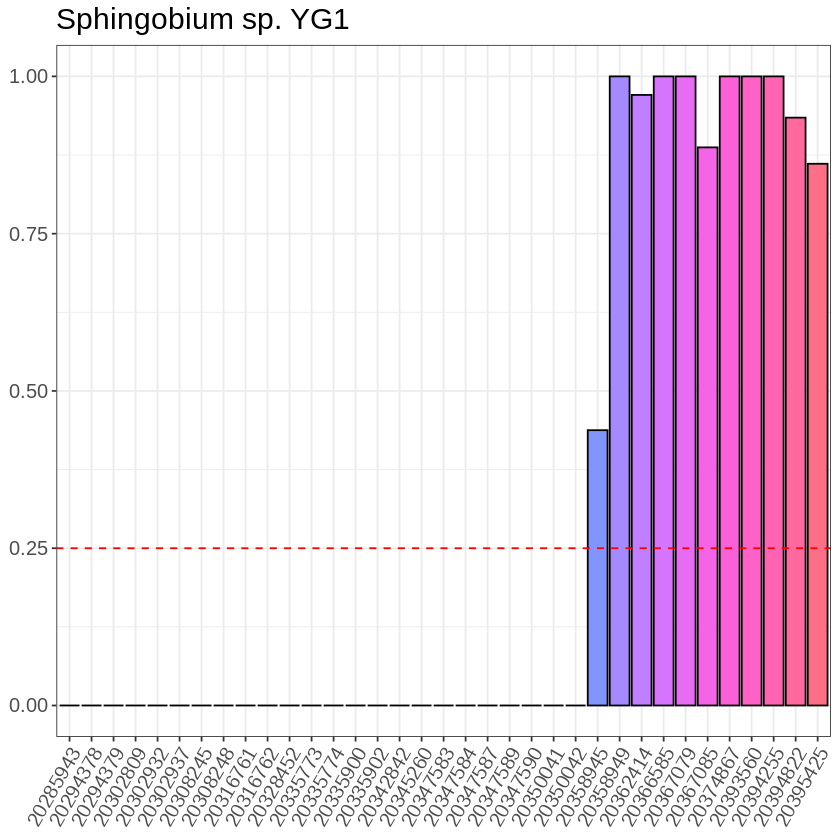

In [19]:
get_prev_plot <- function(taxon) {
    plot_df <- prev_df %>%
        left_join(meta) %>%
        group_by(hiseq_xtm_flow_cell_v2_5_lot) %>%
        summarise(prev = sum(get(taxon)) / n(), n = n()) %>%
        filter(hiseq_xtm_flow_cell_v2_5_lot != "Unknown")
    
    plot_df %>% fwrite(str_glue("results/figure_source_data_nat_micro/contam_versus_nc_prevalence_{taxon}.csv"))
    
    contam_plt <- plot_df %>%
        ggplot(aes(x = hiseq_xtm_flow_cell_v2_5_lot, y = prev, fill = hiseq_xtm_flow_cell_v2_5_lot)) +
            geom_bar(stat = "identity", color = "black") +
            theme_bw() +
            theme(legend.position = "none",
                  axis.text.x = element_text(angle = 60, hjust = 1),
                  axis.title = element_blank(),
                  text = element_text(size = 15)) +
            scale_x_discrete(label = function(x) stringr::str_trunc(x, 20)) +
            labs(x = "Cohort", y = "Prevalence", title = taxon) +
            geom_hline(yintercept = 0.25, 
                       color = "red",
                       lty = "dashed") +
            ylim(0, 1)
     return(contam_plt)
    }
                         
                    
                    
# ggarrange(get_prev_plot("Pseudomonas mendocina"), get_prev_plot("Moraxella osloensis"), 
#           common.legend = T,
#           legend = "none")
# get_prev_plot("Alcaligenes faecalis")   
get_prev_plot("Sphingobium sp. YG1")   
ggsave("results/decontamination/contam_versus_nc_prevalence.pdf", dpi = 600, height = 9, width = 7)

### No. of taxa per sample

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


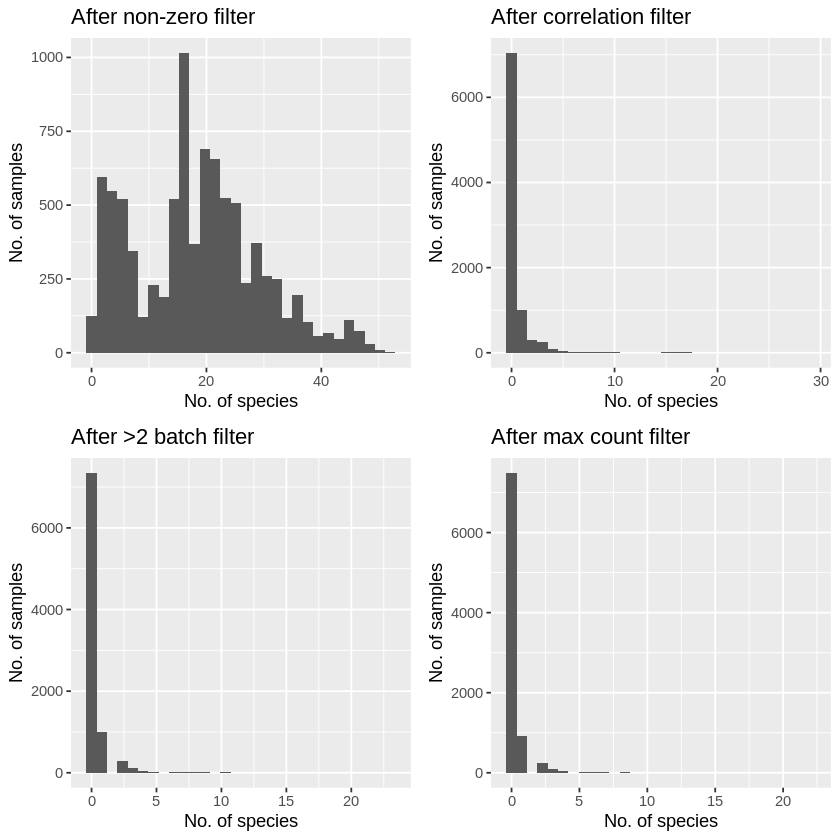

In [20]:
# After PA thresholding
tax_plt <- tibble(n = rowSums(prev_df %>% select(-npm_research_id))) %>%
    ggplot(aes(x = n)) +
    geom_histogram() +
    labs(x = "No. of species", y = "No. of samples", title = "After non-zero filter")

# After correlation decontamination
species_prev_filt1 <- prev_df %>% select(all_of(corr_nc))
tax_plt1 <- tibble(n = rowSums(species_prev_filt1)) %>%
    ggplot(aes(x = n)) +
    geom_histogram() +
    labs(x = "No. of species", y = "No. of samples", title = "After correlation filter")

# After simple batch filter
species_prev_filt2 <- prev_df %>% select(all_of(batch_nc))
tax_plt2 <- tibble(n = rowSums(species_prev_filt2)) %>%
    ggplot(aes(x = n)) +
    geom_histogram() +
    labs(x = "No. of species", y = "No. of samples", title = "After >2 batch filter")


# After max count filter
species_prev_filt3 <- prev_df %>% select(all_of(prev_max_filt$taxa))
tax_plt3 <- tibble(n = rowSums(species_prev_filt3)) %>%
    ggplot(aes(x = n)) +
    geom_histogram() +
    labs(x = "No. of species", y = "No. of samples", title = "After max count filter")

ggarrange(tax_plt, tax_plt1, tax_plt2, tax_plt3)

avg
<dbl>
1


Warning message in geom_histogram(stat = "count"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


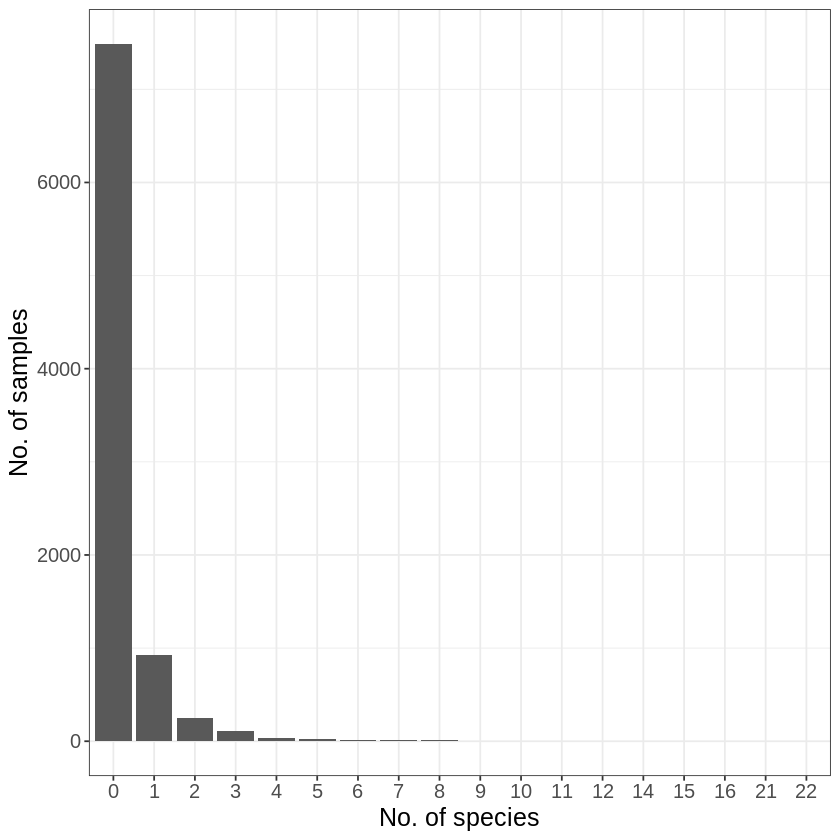

In [21]:
# After max count filter
species_prev_filt3 <- prev_df %>% select(all_of(prev_max_filt$taxa))

tibble(n = rowSums(species_prev_filt3)) %>%
    mutate(n = factor(n)) %>%
    group_by(n) %>%
    summarise(n_total = n()) %>%
    arrange(desc(n_total)) %>%
    fwrite("results/figure_source_data_nat_micro/num_microbes_per_indiv.csv")

tibble(n = rowSums(species_prev_filt3)) %>%
    filter(n != 0) %>%
    summarise(avg = median(n))

tax_plt3 <- tibble(n = rowSums(species_prev_filt3)) %>%
    mutate(n = factor(n)) %>%
    ggplot(aes(x = n)) +
    geom_histogram(stat = "count") +
    labs(x = "No. of species", y = "No. of samples") +
    theme_bw() +
    scale_x_discrete() +
    theme(text = element_text(size = 15))
tax_plt3
ggsave("results/decontamination/num_microbial_species_per_sample.pdf", dpi = 600, width = 8, height = 4)

In [22]:
7487/8892

[1] 0.8419928

## Is sampling depth a problem?

### Abundance of present microbes versus absent microbes

In [23]:
prev_df

npm_research_id,Fusarium graminearum,Toxoplasma gondii,Pseudomonas sp. SXM-1,Pseudomonas tolaasii,Pseudomonas fluorescens,Pseudomonas veronii,Pseudomonas oleovorans,Pseudomonas alcaliphila,Buchnera aphidicola,⋯,Torque teno virus 2,Rickettsia montanensis,Human alphaherpesvirus 2,Streptococcus sp. FDAARGOS_522,Woolly monkey hepatitis B virus,Streptococcus pasteurianus,Rickettsia endosymbiont of Ixodes pacificus,Capuchin monkey hepatitis B virus,Bacillus sp. TK-2,Lactobacillus phage Lv-1
<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
WHB10753,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
WHB9289,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
WHB7247,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
WHB10124,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
WHB8107,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
WHB9315,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
WHB10904,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
WHB8989,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
WHH1247,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


In [24]:
read_mat <- as.matrix(otu_to_RA(species_df) %>%
                      select(all_of(colnames(species_read_final))) %>%
                          column_to_rownames("npm_research_id"))
prev_mat <- as.matrix(prev_df %>% 
                      select(all_of(colnames(species_read_final))) %>%
                      column_to_rownames("npm_research_id"))

In [25]:
dim(prev_mat) == dim(read_mat)

[1] TRUE TRUE

In [26]:
present_microbes <- read_mat[prev_mat]
absent_microbes <- read_mat[!prev_mat]

# Remove zero counts
absent_microbes <- absent_microbes[absent_microbes != 0]

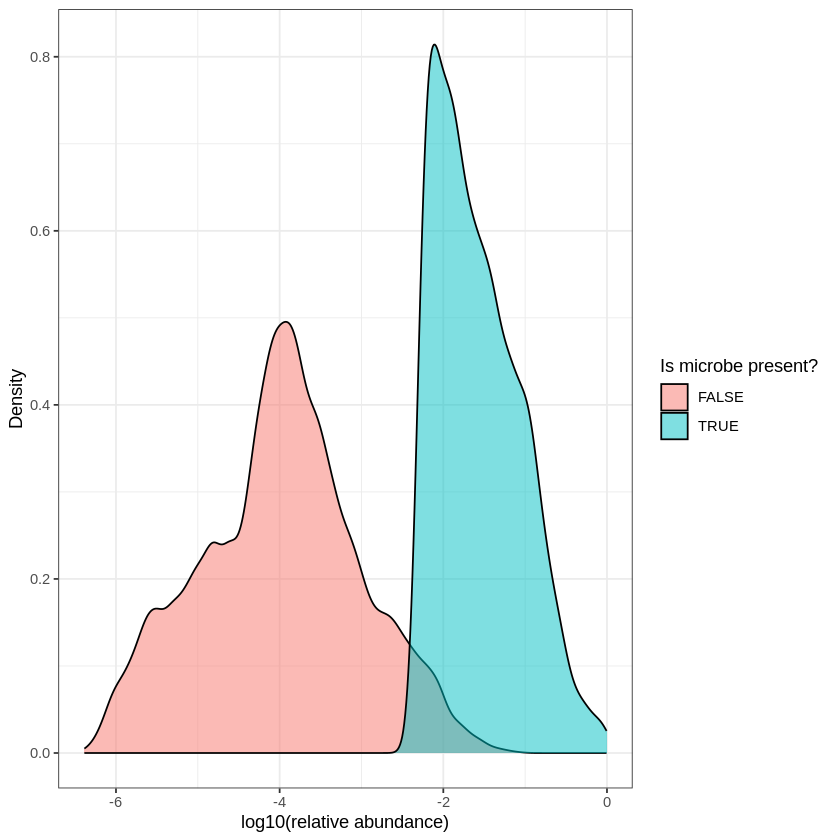

In [60]:
plot_df <- bind_rows(tibble(present = T, read_count = present_microbes),
                     tibble(present = F, read_count = absent_microbes))

plot_df %>% fwrite("results/figure_source_data_nat_micro/present_versus_absent_relative_abundance.csv")

plot_df %>%
    ggplot(aes(x = log10(read_count), fill = present)) +
    geom_density(alpha = 0.5) +
    labs(x = "log10(relative abundance)", y = "Density", fill = "Is microbe present?") +
    theme_bw()

ggsave("results/prevalence_estimates/present_versus_absent_relative_abundance.pdf", dpi = 600, width = 10, height = 3)

### Relationship between no. of species per sample and total microbial reads sampled

Joining with `by = join_by(npm_research_id)`
Saving 6.67 x 6.67 in image
Warning message in cor.test.default(microbe_n_spec$n_species, microbe_n_spec$total_microbial, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  microbe_n_spec$n_species and microbe_n_spec$total_microbial
S = 1.499e+11, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.2792397 


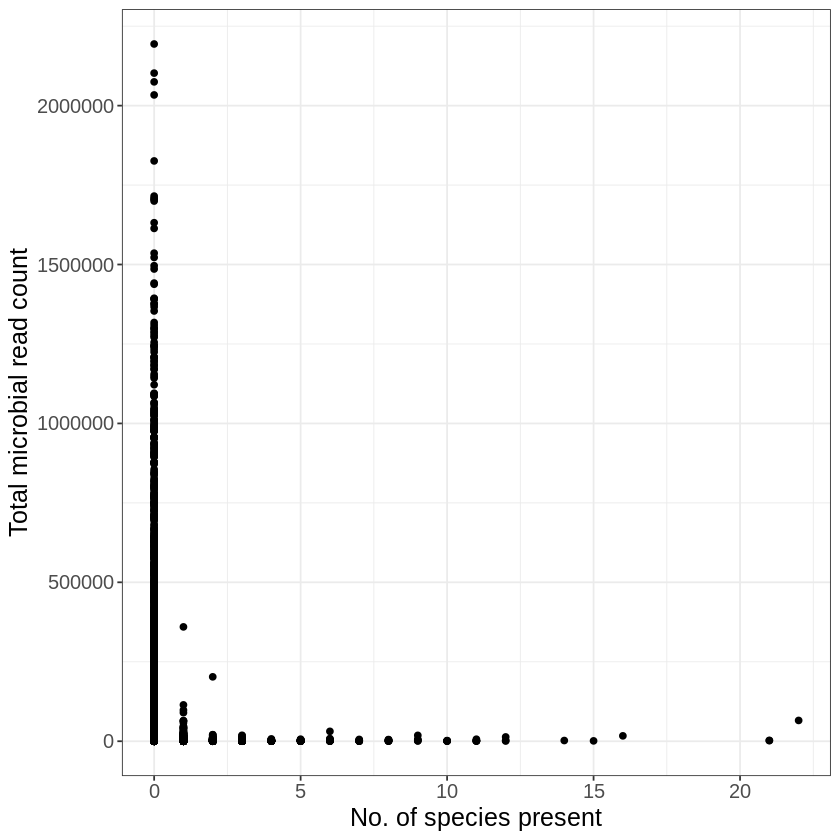

In [28]:
# Total number of microbial reads
total_rowsums <- species_zeroed %>%
    rowSums()

total_rowsums <- tibble(npm_research_id = names(total_rowsums), total_microbial = total_rowsums)

filt_rowsums <- prev_df %>% 
    column_to_rownames("npm_research_id") %>%
    select(all_of(prev_max_filt$taxa)) %>%
    rowSums()

filt_rowsums <- tibble(npm_research_id = names(filt_rowsums), n_species = filt_rowsums)

microbe_n_spec <- total_rowsums %>%
    inner_join(filt_rowsums)

microbe_n_spec %>%
    ggplot(aes(x = n_species, y = total_microbial)) +
    geom_point() +
    labs(x = "No. of species present", y = "Total microbial read count") +
    theme_bw() +
    theme(text = element_text(size = 15))
ggsave("results/decontamination/read_count_n_species_correlation.png", dpi = 600)
cor.test(microbe_n_spec$n_species, microbe_n_spec$total_microbial, method = "spearman")

In [29]:
# microbe_n_spec %>% filter(n_species > 10)
# microbe_n_spec %>% arrange(desc(total_microbial))
# prev_df %>% 
#     filter(npm_research_id == "WHB3479") %>%
#     pivot_longer(!npm_research_id, names_to = "taxa", values_to = "presence") %>%
#     filter(presence)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 124 rows containing non-finite values (`stat_bin()`).”


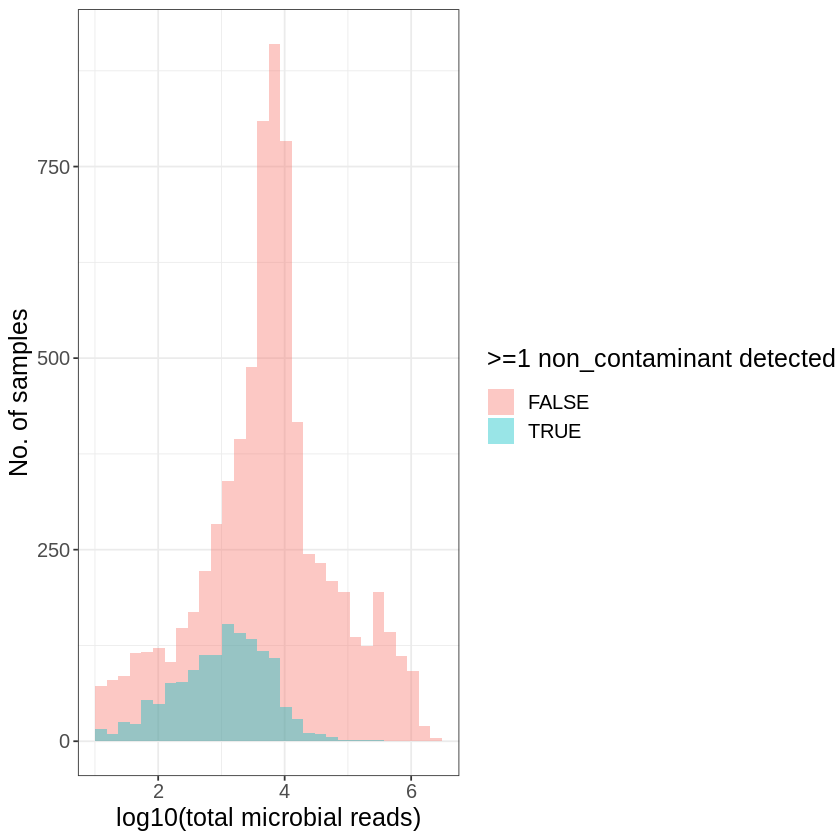

In [30]:
non_zero_microbes <- microbe_n_spec %>% 
    mutate(non_zero = ifelse(n_species > 0, T, F))
# med_read <- non_zero_microbes %>%
#     summarise(median = median(total_microbial))
# med_read <- med_read$median

non_zero_microbes %>% 
    ggplot(aes(x = log(total_microbial, base = 10), fill = non_zero)) +
    geom_histogram(position = "identity", alpha = 0.4) +
#     geom_text(aes(x = 1, y = 900, label = str_glue("n = {nrow(zero_microbes)}"))) +
    theme_bw() +
    theme(text = element_text(size = 15)) +
    labs(x = "log10(total microbial reads)", y = "No. of samples", fill = ">=1 non_contaminant detected") 

# ggsave("results/decontamination/zero_microbe_read_distribution.png", dpi = 600)

# Range of reads
# range(zero_microbes$total_microbial)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 124 rows containing non-finite values (`stat_bin()`).”
Saving 6.67 x 6.67 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 124 rows containing non-finite values (`stat_bin()`).”


[1]       0 2193889

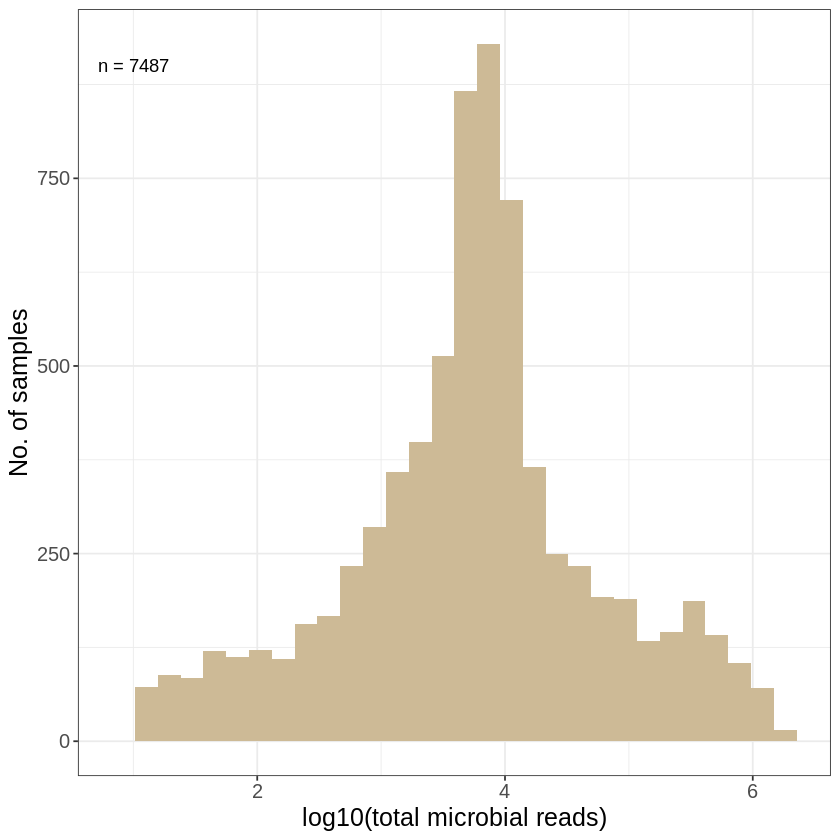

In [55]:
zero_microbes <- microbe_n_spec %>% 
    filter(n_species == 0)
med_read <- zero_microbes %>%
    summarise(median = median(total_microbial))
med_read <- med_read$median

zero_microbes %>% fwrite("results/figure_source_data_nat_micro/zero_microbe_read_distribution.csv")

zero_microbes %>% 
    ggplot(aes(x = log(total_microbial, base = 10))) +
    geom_histogram(fill = "wheat3") +
    annotate("text", x = 1, y = 900, label = str_glue("n = {nrow(zero_microbes)}")) +
    theme_bw() +
    theme(text = element_text(size = 15)) +
    labs(x = "log10(total microbial reads)", y = "No. of samples")

ggsave("results/decontamination/zero_microbe_read_distribution.pdf", dpi = 600)

# Range of reads
range(zero_microbes$total_microbial)

### Is viral prevalence related to microbial read depth?

Joining with `by = join_by(npm_research_id)`
`summarise()` has grouped output by 'read_bin'. You can override using the `.groups` argument.
Saving 6.67 x 8 in image


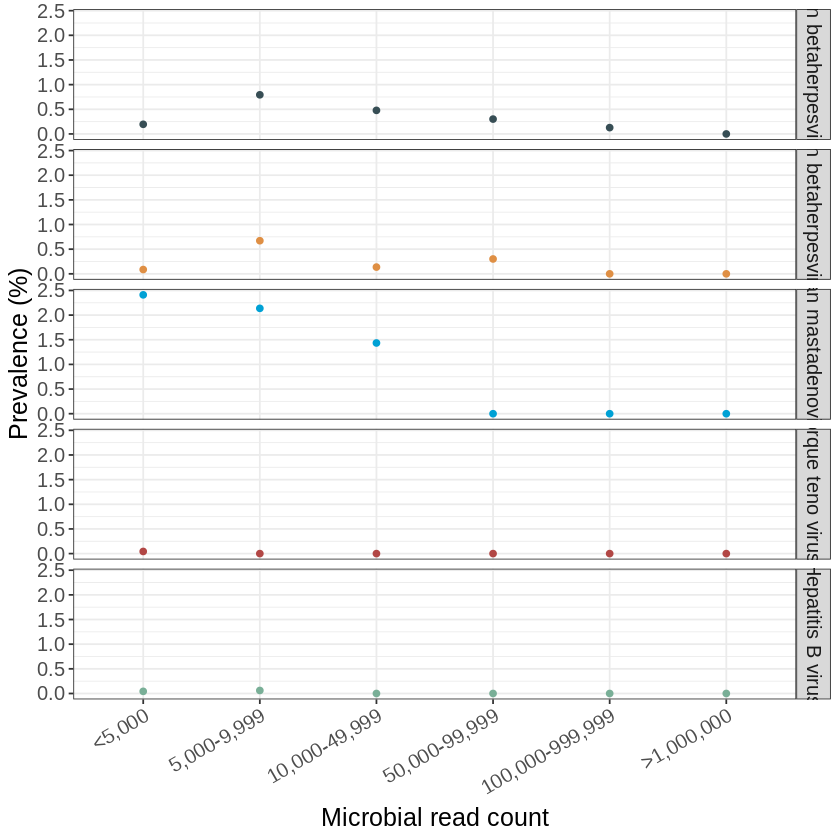

In [32]:
prev_df %>%
    select(npm_research_id, all_of(prev_max_filt$taxa)) %>%
    select(npm_research_id, contains("virus")) %>%
    pivot_longer(!npm_research_id, names_to = "taxa", values_to = "presence") %>%
    left_join(total_rowsums) %>%
    mutate(read_bin = case_when(total_microbial  < 5000 ~ "<5,000",
                     total_microbial >= 5000 & total_microbial < 10000 ~ "5,000-9,999",
                     total_microbial >= 10000 & total_microbial < 50000 ~ "10,000-49,999",
                     total_microbial >= 50000 & total_microbial < 100000 ~ "50,000-99,999",
                     total_microbial >= 100000 & total_microbial < 1000000 ~ "100,000-999,999",
                     total_microbial >= 1000000 ~ ">1,000,000")) %>%
    mutate(read_bin = factor(read_bin, c("<5,000", "5,000-9,999", 
                                         "10,000-49,999", "50,000-99,999",
                                         "100,000-999,999", ">1,000,000")),
           taxa = factor(taxa, c("Human betaherpesvirus 6B",
                                 "Human betaherpesvirus 6A",
                                 "Human mastadenovirus C",
                                 "Torque teno virus 6",
                                 "Hepatitis B virus"))) %>%
    group_by(read_bin, taxa) %>%
    summarise(n_pos = sum(presence), n = n(), prev = sum(presence) / n()) %>%
    ggplot(aes(x = read_bin, y = prev * 100, color = taxa)) +
    geom_point() +
    facet_grid(rows = vars(taxa)) +
#     geom_text(aes(y = -0.1, label = paste0("n = ", n)), color = "black") +
    labs(x = "Microbial read count", y = "Prevalence (%)", color = "Viral species") +
    theme_bw() +
    theme(legend.position = "none",
          axis.text.x = element_text(angle = 30, hjust = 1),
          text = element_text(size = 15)) +
    scale_color_jama()
ggsave("results/decontamination/read_count_viral_prevalence_correlation.png", dpi = 600, height = 8)

Joining with `by = join_by(npm_research_id)`
`summarise()` has grouped output by 'read_bin'. You can override using the `.groups` argument.
Saving 6.67 x 6.67 in image


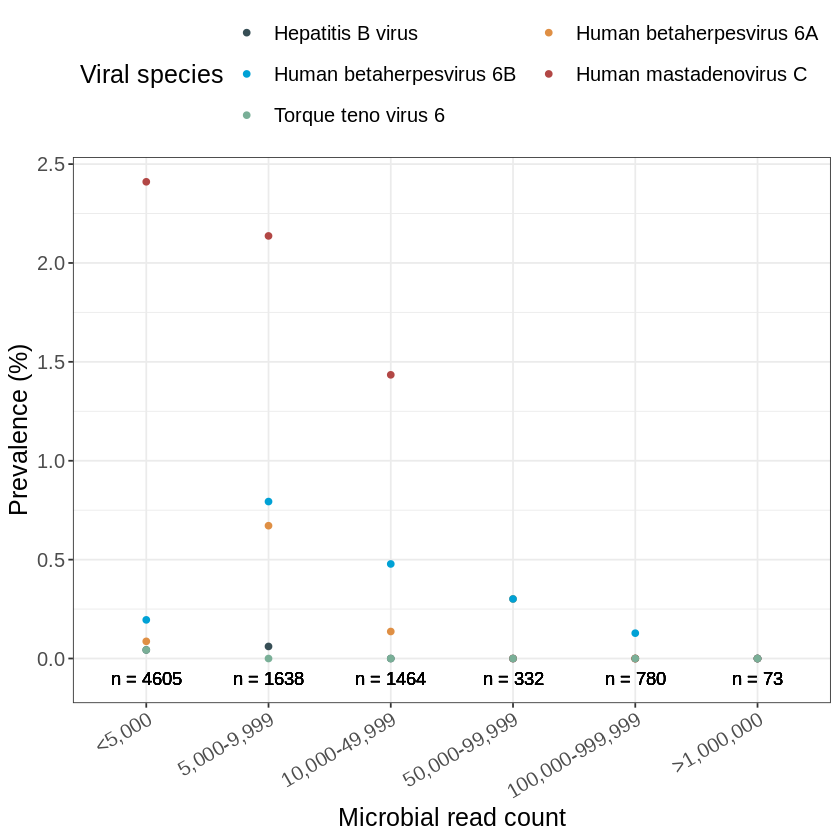

In [33]:
prev_df %>%
    select(npm_research_id, all_of(prev_max_filt$taxa)) %>%
    select(npm_research_id, contains("virus")) %>%
    pivot_longer(!npm_research_id, names_to = "taxa", values_to = "presence") %>%
    left_join(total_rowsums) %>%
    mutate(read_bin = case_when(total_microbial  < 5000 ~ "<5,000",
                     total_microbial >= 5000 & total_microbial < 10000 ~ "5,000-9,999",
                     total_microbial >= 10000 & total_microbial < 50000 ~ "10,000-49,999",
                     total_microbial >= 50000 & total_microbial < 100000 ~ "50,000-99,999",
                     total_microbial >= 100000 & total_microbial < 1000000 ~ "100,000-999,999",
                     total_microbial >= 1000000 ~ ">1,000,000")) %>%
    mutate(read_bin = factor(read_bin, c("<5,000", "5,000-9,999", 
                                         "10,000-49,999", "50,000-99,999",
                                         "100,000-999,999", ">1,000,000"))) %>%
    group_by(read_bin, taxa) %>%
    summarise(n_pos = sum(presence), n = n(), prev = sum(presence) / n()) %>%
    ggplot(aes(x = read_bin, y = prev * 100, color = taxa)) +
    geom_point() +
    geom_text(aes(y = -0.1, label = paste0("n = ", n)), color = "black") +
    labs(x = "Microbial read count", y = "Prevalence (%)", color = "Viral species") +
    theme_bw() +
    guides(color = guide_legend(nrow = 3, byrow = TRUE)) +
    theme(legend.position = "top", 
          axis.text.x = element_text(angle = 30, hjust = 1),
          text = element_text(size = 15)) +
    scale_color_jama()
ggsave("results/decontamination/read_count_viral_prevalence_correlation.png", dpi = 600)

## Demonstrating batch effects within kits

In [34]:
all_contams <- colnames(prev_df)[!(colnames(prev_df) %in% colnames(species_read_final))]

heatmap_df <- prev_df %>%
    pivot_longer(!npm_research_id, names_to = "taxa", values_to = "presence") %>%
    filter(taxa %in% all_contams) %>%
    left_join(meta) %>%
    select(npm_research_id, taxa, presence, extraction_kit, hiseq_xtm_sbs_kit_300_cycles_v2__box_1of_2__lot) %>%
    pivot_longer(!c(npm_research_id, taxa, presence), names_to = "batch_type", values_to = "batch") %>%
    group_by(taxa, batch_type, batch) %>%
    summarise(prevalence = sum(presence) / n()) %>%
    filter(batch != "Unknown") %>%
    ungroup()

Joining with `by = join_by(npm_research_id)`
`summarise()` has grouped output by 'taxa', 'batch_type'. You can override using the `.groups` argument.


#### Hierarchical clustering

In [35]:
mat <- heatmap_df %>% 
    pivot_wider(id_cols = c(batch), names_from = "taxa", values_from = "prevalence") %>%
    column_to_rownames("batch")

hc.rows <- hclust(dist(mat))
hc.cols <- hclust(dist(t(mat)))

row_levels <- rownames(mat)[hc.rows$order]
col_levels <- colnames(mat)[hc.cols$order]

#### Visualise

In [36]:
plot_df <- prev_df %>%
    pivot_longer(!npm_research_id, names_to = "taxa", values_to = "presence") %>%
    filter(taxa %in% all_contams) %>%
    left_join(meta) %>%
    select(npm_research_id, taxa, presence, extraction_kit, hiseq_xtm_sbs_kit_300_cycles_v2__box_1of_2__lot) %>%
    pivot_longer(!c(npm_research_id, taxa, presence), names_to = "batch_type", values_to = "batch") %>%
    group_by(taxa, batch_type, batch) %>%
    summarise(prevalence = sum(presence) / n()) %>%
    filter(batch != "Unknown") %>%
    mutate(taxa = factor(taxa, levels = col_levels),
           batch = factor(batch, levels = row_levels),
           batch_type = factor(batch_type, levels = c("hiseq_xtm_sbs_kit_300_cycles_v2__box_1of_2__lot", "extraction_kit")),
           prevalence = ifelse(prevalence == 0, NA, prevalence)) %>%
    separate(taxa, c("genus"), sep = " ", remove = F) %>%
    arrange(genus)

Joining with `by = join_by(npm_research_id)`
`summarise()` has grouped output by 'taxa', 'batch_type'. You can override using the `.groups` argument.
Warning message:
“Expected 1 pieces. Additional pieces discarded in 29367 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


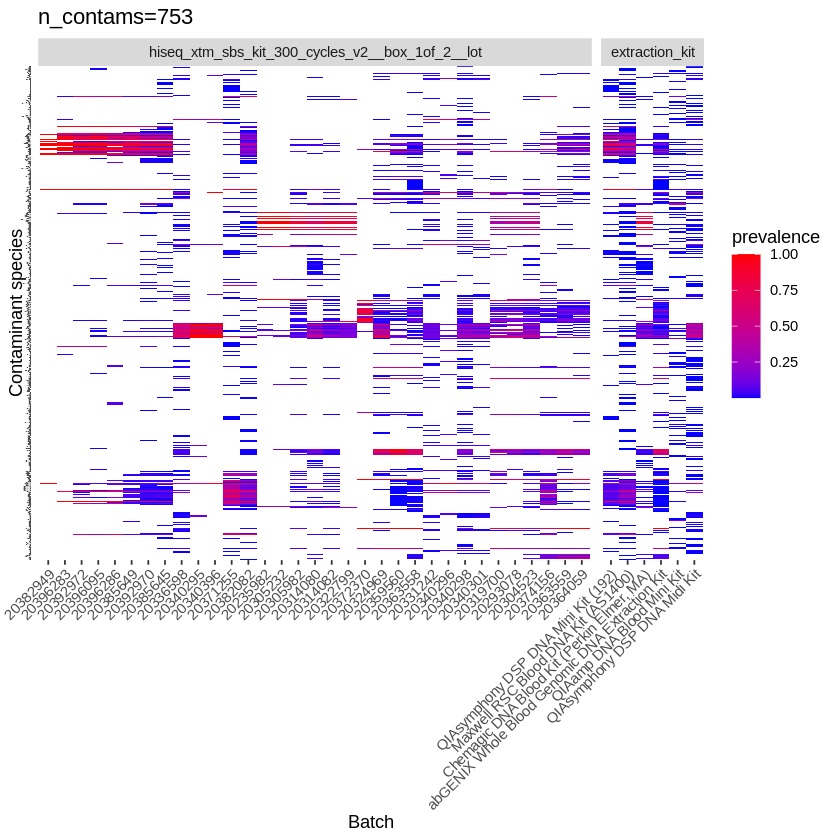

In [37]:
plot_df %>%
    mutate(taxa = factor(taxa, unique(plot_df$taxa))) %>%
    ggplot(aes(x = batch, y = taxa, fill = prevalence)) +
    facet_grid(cols = vars(batch_type),
               scales = "free_x", space = "free_x") +
    geom_tile() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          axis.text.y = element_text(size = 0.5),
          axis.ticks.y = element_blank()) +
    scale_fill_gradient(low = "blue", high = "red", na.value = "white") +
    labs(x = "Batch", y = "Contaminant species", title = paste0("n_contams=", length(all_contams)))

plot_df %>% fwrite("prevalence_heatmap_contaminants.species_names.csv")

ggsave("results/decontamination/prevalence_heatmap_contaminants.species_names.pdf", dpi = 600, width = 30, height = 30)

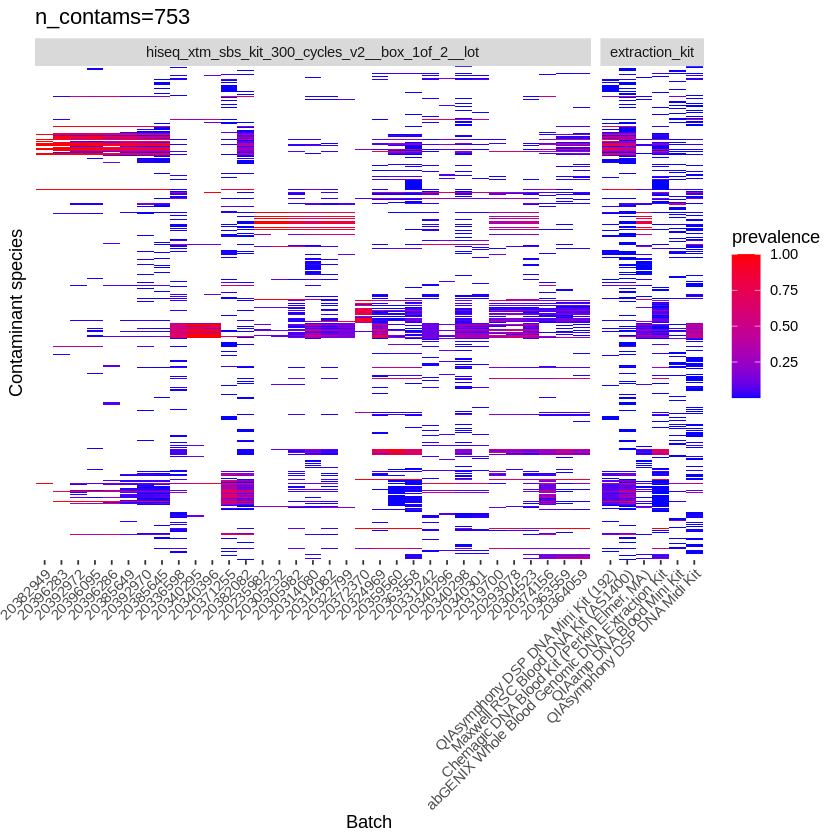

In [38]:
plot_df %>%
    mutate(taxa = factor(taxa, unique(plot_df$taxa))) %>%
    ggplot(aes(x = batch, y = taxa, fill = prevalence)) +
    facet_grid(cols = vars(batch_type),
               scales = "free_x", space = "free_x") +
    geom_tile() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank()) +
    scale_fill_gradient(low = "blue", high = "red", na.value = "white") +
    labs(x = "Batch", y = "Contaminant species", title = paste0("n_contams=", length(all_contams)))

ggsave("results/decontamination/prevalence_heatmap_contaminants.pdf", dpi = 600, width = 8, height = 6)

## No. of microbial reads per sample

### Contaminant to non-contaminant ratio

In [39]:
total_rowsums <- species_zeroed %>%
    rowSums()
nc_rowsums <- species_read_final %>%
    column_to_rownames("npm_research_id") %>%
    rowSums()

tibble(npm_research_id = names(total_rowsums), total_microbial = total_rowsums) %>%
    left_join(tibble(npm_research_id = names(nc_rowsums), nc_microbial = nc_rowsums)) %>%
    mutate(contam_microbial = total_microbial - nc_microbial) %>%
    mutate(ratio = nc_microbial / contam_microbial) %>%
    filter(!is.na(ratio)) %>%
    summarise(median_ratio = median(ratio))

Joining with `by = join_by(npm_research_id)`


median_ratio
<dbl>
0


In [40]:
total_rowsums <- species_zeroed %>%
    rowSums()

In [41]:
total_rowsums <- species_df %>%
    column_to_rownames("npm_research_id") %>%
    rowSums()
nc_rowsums <- species_read_final %>%
    column_to_rownames("npm_research_id") %>%
    rowSums()
max(total_rowsums)
max(nc_rowsums)

[1] 2434452

[1] 197837

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 7487 rows containing non-finite values (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 7487 rows containing non-finite values (`stat_bin()`).”


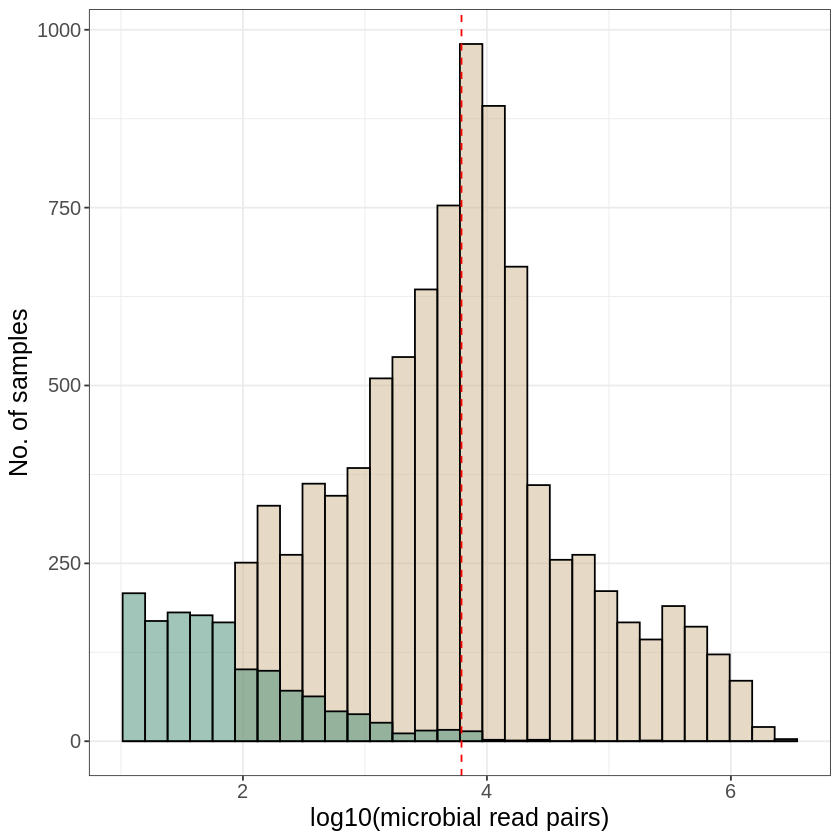

In [42]:
total_rowsums <- species_df %>%
    column_to_rownames("npm_research_id") %>%
    rowSums()
nc_rowsums <- species_read_final %>%
    column_to_rownames("npm_research_id") %>%
    rowSums()

med_nc <- median(log(nc_rowsums, 10))
med_total <- median(log(total_rowsums, 10))

read_plot_df <- tibble(n = total_rowsums, group = "total") %>%
    bind_rows(tibble(n = nc_rowsums, group = "nc")) %>%
    mutate(log_n = log(n, base = 10))

read_plot_df %>%
    ggplot() +
    geom_histogram(data = read_plot_df %>% filter(group == "total"),
                   aes(x = log_n),
                   fill = "navajowhite3",
                   color = "black",
                   alpha = 0.5) +
    geom_histogram(data = read_plot_df %>% filter(group == "nc"),
                   aes(x = log_n),
                   fill = "aquamarine4",
                   color = "black",
                   alpha = 0.5) +
    geom_vline(xintercept = med_total, 
               color = "red",
               lty = "dashed") +
    theme_bw() +
    labs(x = "log10(microbial read pairs)", y = "No. of samples") +
    theme(text = element_text(size = 15))
    
ggsave("results/decontamination/total_microbial_reads.png", dpi = 600, width = 5, height = 5)

In [43]:
median(total_rowsums)

[1] 6186.5

## Decontaminated taxonomic profiles

### Site level

In [44]:
curated_taxa <- fread("results/decontamination/curated_n117_global_decontamination_stats.parsed.csv")
site_list <- unique(curated_taxa$site)
site_list <- site_list[!(site_list %in% c("", "blood", "eye"))]

# taxa_lists <- list()

# for(site_name in site_list) {
#     taxa_lists[[site_name]] <- (curated_taxa %>% filter(site == site_name))$taxa
# }

# venn.diagram(
#   x = taxa_lists[1:5],
#   category.names = names(taxa_lists)[1:5],
#   filename = "results/decontamination/site_grouping.venn.png"
# )


In [45]:
curated_taxa %>% 
    group_by(site) %>%
    summarise(n = n()) %>%
    arrange(desc(n))

site,n
<chr>,<int>
,57
gut,40
oral,32
genitourinary tract,18
skin,15
respiratory tract,9
blood,6
eye,1


In [46]:
n_empty <- curated_taxa %>% 
    distinct(taxa, .keep_all = T) %>%
    filter(site == "") %>%
    nrow()
(nrow(curated_taxa %>% distinct(taxa)) - n_empty)
(nrow(curated_taxa %>% distinct(taxa)) - n_empty) / n_final

[1] 60

[1] 0.5128205

In [47]:
single_site_taxa <- curated_taxa %>%
#     filter(site != "skin") %>%
    filter(site != "") %>%
    group_by(taxa) %>%
    summarise(n_sites = n()) %>%
    filter(n_sites == 1)
# single_site_taxa <- single_site_taxa$taxa
nrow(single_site_taxa)

single_site_taxa %>%
    left_join(curated_taxa %>% select(taxa, site)) %>%
    filter(site != "skin")

[1] 26

Joining with `by = join_by(taxa)`


taxa,n_sites,site
<chr>,<int>,<chr>
Acinetobacter baumannii,1,oral
Anaerostipes hadrus,1,gut
Bifidobacterium adolescentis,1,gut
Bifidobacterium catenulatum,1,gut
Blautia obeum,1,gut
Clostridium innocuum,1,gut
Coprococcus comes,1,gut
Corynebacterium jeikeium,1,gut
Corynebacterium tuberculostearicum,1,respiratory tract


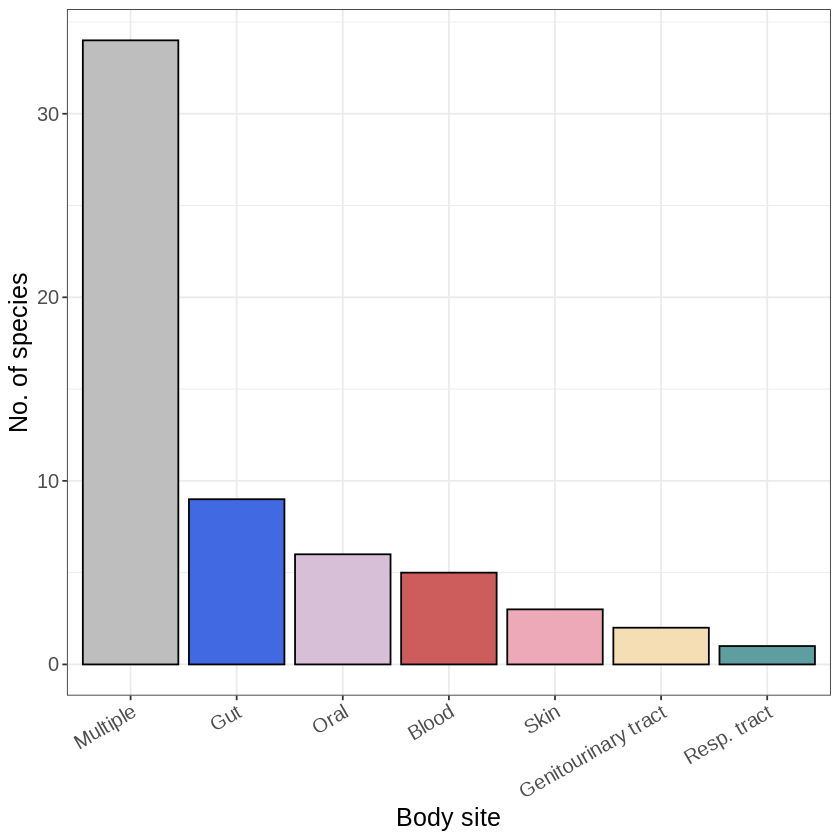

In [48]:
site_morsels <- foreach(taxon = unique(curated_taxa$taxa)) %do% {
    temp <- curated_taxa %>%
        filter(taxa == taxon)
    if (nrow(temp) > 1) {
        temp %>% 
            distinct(taxa, .keep_all = T) %>%
            mutate(site = "Multiple")
    } else {
        temp
    }
}

site_plot_df <- bind_rows(site_morsels) %>%
    mutate(site = Hmisc::capitalize(site)) %>%
    mutate(site = ifelse(site == "Respiratory tract", "Resp. tract", site)) %>%
    filter(site != "") %>%
    group_by(site) %>%
    summarise(n_site = n()) %>%
    arrange(desc(n_site))

site_plot_df %>%
    mutate(site = factor(site, unique(site_plot_df$site))) %>%
    ggplot(aes(x = site, y = n_site, fill = site)) +
    geom_bar(stat = "identity", color = "black") +
    theme_bw() +
    labs(x = "Body site", y = "No. of species") +
    scale_fill_manual(values = c("grey", "royalblue", "thistle",
                                 "indianred", "pink2", "wheat",
                                   "cadetblue")) +
    theme(legend.position = "none",
          axis.text.x = element_text(angle = 30, hjust = 1),
          text = element_text(size = 15))

site_plot_df %>% fwrite("results/figure_source_data_nat_micro/body_site_counts.csv")
ggsave("results/decontamination/body_site_counts.pdf", dpi = 600, width = 8, height = 4)

### Microbiology classification

In [49]:
jama_pal <- pal_jama("default")(5)
jama_pal[1] <- "slategray3"

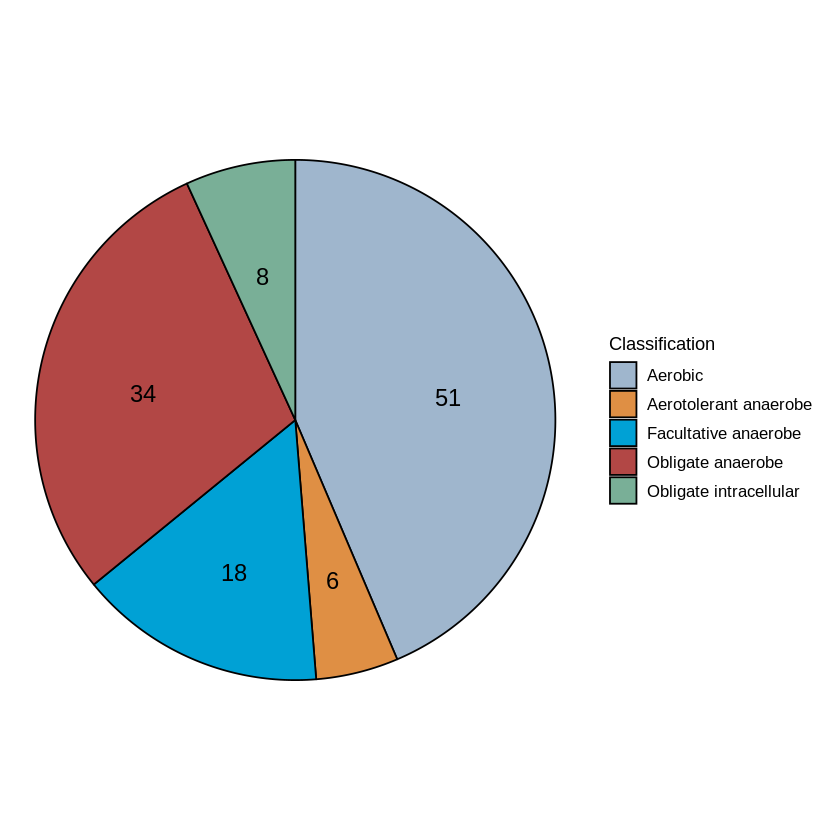

In [50]:
rpie <- 1
rlabel <-  0.6 * rpie

taxa_pie_df <- curated_taxa %>%
    distinct(taxa, .keep_all = T) %>%
    group_by(microbiol_class) %>%
    summarise(cnt = n(), total = nrow(df))

taxa_pie_df %>% fwrite("results/figure_source_data_nat_micro/microbiology_breakdown.csv")

taxa_pie_df %>%
    mutate(end_angle = 2 * pi * cumsum(cnt) / n_distinct(curated_taxa$taxa),      # ending angle for each pie slice
           start_angle = lag(end_angle, default = 0),   # starting angle for each pie slice
           mid_angle = 0.5 * (start_angle + end_angle)) %>%  # middle of each pie slice, for the text label
    ggplot() +
    geom_arc_bar(aes(x0 = 0, y0 = 0, r0 = 0, r = rpie,
                start = start_angle, end = end_angle, fill = microbiol_class)) +
    geom_text(aes(x = rlabel * sin(mid_angle), y = rlabel * cos(mid_angle), label = cnt),
                hjust = 0.5, vjust = 1, size = 5) +
    coord_fixed() +
    scale_x_continuous(limits = c(-1, 1), name = "", breaks = NULL, labels = NULL) +
    scale_y_continuous(limits = c(-1, 1), name = "", breaks = NULL, labels = NULL) +
    scale_fill_manual(values = jama_pal) +
    theme(legend.text = element_text(size = 10),
          panel.background = element_rect(fill = "white"),
          axis.text = element_blank(),
          axis.title = element_blank(),
          axis.ticks = element_blank()) +
    labs(x = NULL, y = NULL, fill = NULL) +
    labs(fill = "Classification")

ggsave("results/decontamination/microbiology_breakdown.pdf", dpi = 600, height = 3, width = 5)

### Genus level

In [51]:
curated_taxa %>%
    distinct(taxa, .keep_all = T) %>%
    distinct(genus)

genus
<chr>
Fusobacterium
Cutibacterium
Mastadenovirus
Neisseria
Corynebacterium
Haemophilus
Fannyhessea
Staphylococcus
Roseolovirus


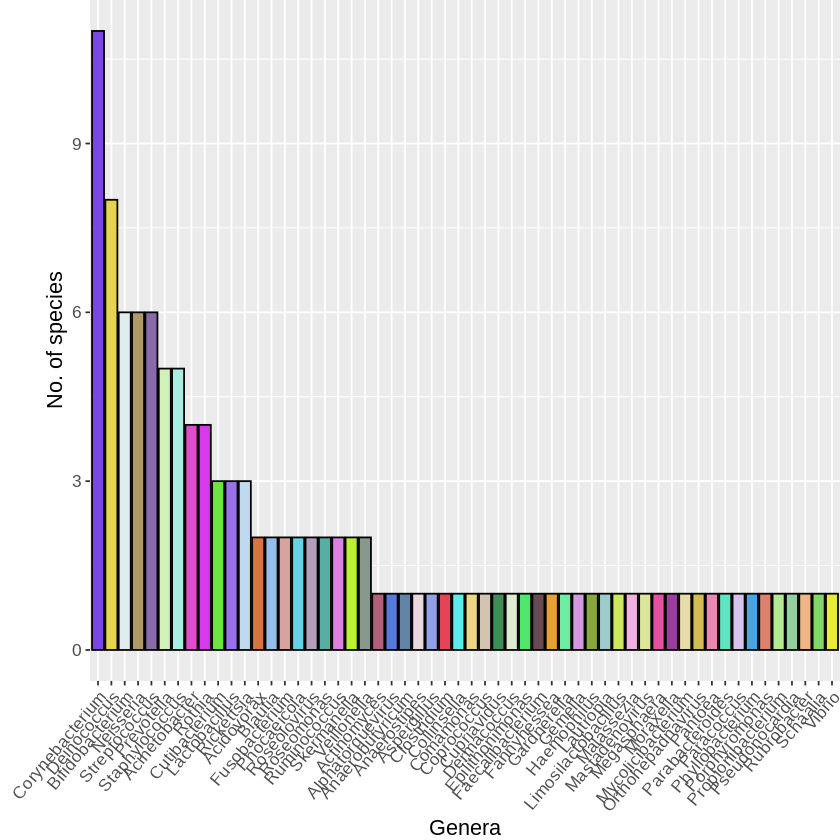

In [52]:
genus_plot_df <- curated_taxa %>%
    distinct(taxa, .keep_all = T) %>%
    group_by(genus) %>%
    summarise(n_species = n()) %>%
    arrange(desc(n_species))

# top10_genera <- genus_plot_df %>% head(30)
# other_genera <- genus_plot_df %>% 
#     filter(!(genus %in% top10_genera$genus)) %>%
#     summarise(genus = "Others", n_species = sum(n_species))

# bind_rows(top10_genera, other_genera) %>%
#     mutate(genus = factor(genus, c(genus_plot_df$genus, "Others"))) %>%
#     ggplot(aes(x = genus, y = n_species)) +
#     geom_bar(stat = "identity") +
#     theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

set.seed(66)
pal <- distinctColorPalette(length(unique(genus_plot_df$genus)))

genus_plot_df %>%
    mutate(genus = factor(genus, c(genus_plot_df$genus, "Others"))) %>%
    ggplot(aes(x = genus, y = n_species, fill = genus)) +
    geom_bar(stat = "identity", color = "black") +
    theme(legend.position = "none",
          axis.text.x = element_text(angle = 50, hjust = 1),
          plot.margin = unit(c(0, 0, 0, 1), "cm"),
          text = element_text(size = 13)) +
    labs(x = "Genera", y = "No. of species") +
    scale_fill_manual(values = pal)

ggsave("results/decontamination/genus_breakdown.png", dpi = 600, width = 10, height = 3)

### Species level

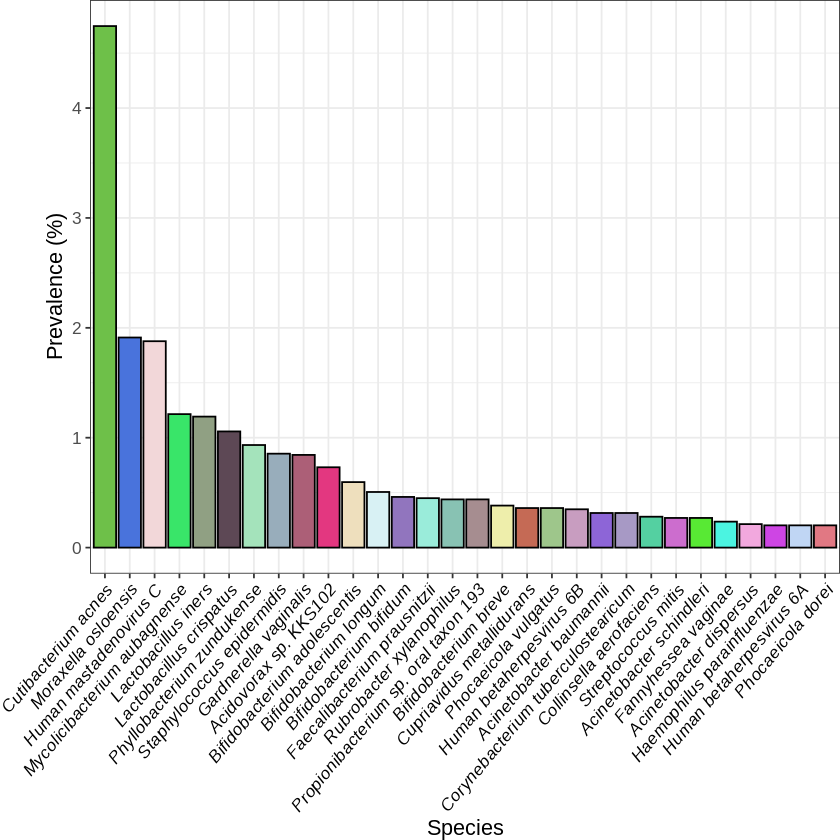

In [53]:
species_plot_df <- curated_taxa %>%
    distinct(taxa, .keep_all = T) %>%
    arrange(desc(overall_prevalence))

set.seed(67)
pal2 <- distinctColorPalette(length(unique(species_plot_df$taxa)))

species_plot_df <- species_plot_df %>%
    head(30)

species_plot_df %>% fwrite("results/figure_source_data_nat_micro/species_prevalence.csv")

species_plot_df %>%
    mutate(taxa = factor(taxa, c(species_plot_df$taxa))) %>%
    ggplot(aes(x = taxa, y = overall_prevalence * 100, fill = taxa)) +
    geom_bar(stat = "identity", color = "black") +
    theme_bw() + 
    theme(legend.position = "none",
          axis.text.x = element_text(angle = 50, 
                                     hjust = 1, 
                                     face = "italic",
                                     color = "black"),
          plot.margin = unit(c(0, 0, 0, 1), "cm"),
          text = element_text(size = 13)) +
    labs(x = "Species", y = "Prevalence (%)") +
    scale_fill_manual(values = pal2)

ggsave("results/decontamination/species_prevalence.pdf", dpi = 600, width = 7, height = 4)